# 📚 IMPORTAÇÃO DE BIBLIOTECAS

In [1]:
# Instalação de dependências
%pip install pandas numpy matplotlib seaborn requests plotly scikit-learn IPython scipy

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from IPython.display import HTML, display
import os

print("✅ Bibliotecas carregadas com sucesso!")
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Bibliotecas carregadas com sucesso!


# 📥 EXTRAÇÃO DOS DADOS

In [2]:
# Carregamento do arquivo de dados
try:
    df = pd.read_csv('churn_data_processed.csv')
    print("✅ Arquivo 'churn_data_processed.csv' carregado com sucesso!")
    print(df.info())
    print("\nPrimeiras linhas do dataset:")
    print(df.head())
except FileNotFoundError:
    print("❌ Erro: Arquivo 'churn_data_processed.csv' não encontrado. Certifique-se de que ele está no diretório correto.")

✅ Arquivo 'churn_data_processed.csv' carregado com sucesso!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   d                       7043 non-null   object 
 1   churn                   7043 non-null   object 
 2   gender                  7043 non-null   object 
 3   seniorcitizen           7043 non-null   int64  
 4   partner                 7043 non-null   object 
 5   dependents              7043 non-null   object 
 6   tenure                  7043 non-null   int64  
 7   phoneservice            7043 non-null   object 
 8   multiplelines           7043 non-null   object 
 9   internetservice         7043 non-null   object 
 10  onlinesecurity          7043 non-null   object 
 11  onlinebackup            7043 non-null   object 
 12  deviceprotection        7043 non-null   object 
 13  techsupport             7043 non-

# 🔧 TRANSFORMAÇÃO DOS DADOS

In [5]:
# Padronizar nomes das colunas
df.columns = df.columns.str.lower().str.replace('.', '_', regex=False).str.replace(' ', '_', regex=False)

# Renomear colunas específicas
rename_map = {
    'customerid': 'customer_id',
    'monthlycharges': 'monthly',
    'totalcharges': 'total'
}
df = df.rename(columns=rename_map)

# Garantir nomes de colunas únicos
cols = pd.Series(df.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
df.columns = cols

# Verificar e tratar valores ausentes
print("\nValores ausentes antes do tratamento:")
print(df.isnull().sum())

# Tratar valores ausentes em colunas numéricas
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Tratar valores ausentes em colunas categóricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Limpar a coluna 'churn'
df = df[df['churn'].isin(['Yes', 'No'])].copy()
df['churn_numeric'] = df['churn'].map({'Yes': 1, 'No': 0})

# Converter e limpar a coluna 'total'
df['total'] = pd.to_numeric(df['total'], errors='coerce')
df['total'] = df['total'].fillna(df['monthly'])

# Tratar outliers em colunas numéricas
def cap_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

for col in ['tenure', 'monthly', 'total']:
    if col in df.columns:
        df[col] = cap_outliers(df[col])

# Feature engineering
# Razão entre tempo de contrato e cobrança mensal
df['tenure_to_monthly_ratio'] = df['tenure'] / df['monthly'].replace(0, 1)  # Evitar divisão por zero

# Contagem de serviços premium (ex.: onlinesecurity, techsupport, etc.)
service_cols = [col for col in df.columns if col in ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']]
df['service_bundle'] = df[service_cols].eq('Yes').sum(axis=1)

# Identificar tipos de colunas
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remover colunas irrelevantes para modelagem
numeric_features.remove('churn_numeric')
if 'customer_id' in categorical_features:
    categorical_features.remove('customer_id')
if 'churn' in categorical_features:
    categorical_features.remove('churn')

# Validar dados categóricos
for col in categorical_features:
    unique_vals = df[col].unique()
    if len(unique_vals) > 50:
        print(f"⚠️ Aviso: Coluna '{col}' tem {len(unique_vals)} valores únicos. Considere reduzir a cardinalidade.")

print("\n✅ Dados limpos e transformados com sucesso!")
print(f"Features numéricas: {numeric_features}")
print(f"Features categóricas: {categorical_features}")
print("\nValores ausentes após o tratamento:")
print(df.isnull().sum())


Valores ausentes antes do tratamento:
d                          0
churn                      0
gender                     0
seniorcitizen              0
partner                    0
dependents                 0
tenure                     0
phoneservice               0
multiplelines              0
internetservice            0
onlinesecurity             0
onlinebackup               0
deviceprotection           0
techsupport                0
streamingtv                0
streamingmovies            0
contract                   0
paperlessbilling           0
paymentmethod              0
monthly                    0
total                      0
avg_monthly_spend          0
tenure_group               0
spending_category          0
premium_services_count     0
churn_numeric              0
tenure_to_monthly_ratio    0
service_bundle             0
dtype: int64
⚠️ Aviso: Coluna 'd' tem 7043 valores únicos. Considere reduzir a cardinalidade.

✅ Dados limpos e transformados com sucesso!
Features n

# 📊 ANÁLISE EXPLORATÓRIA (EDA)

=== Análise Univariada ===


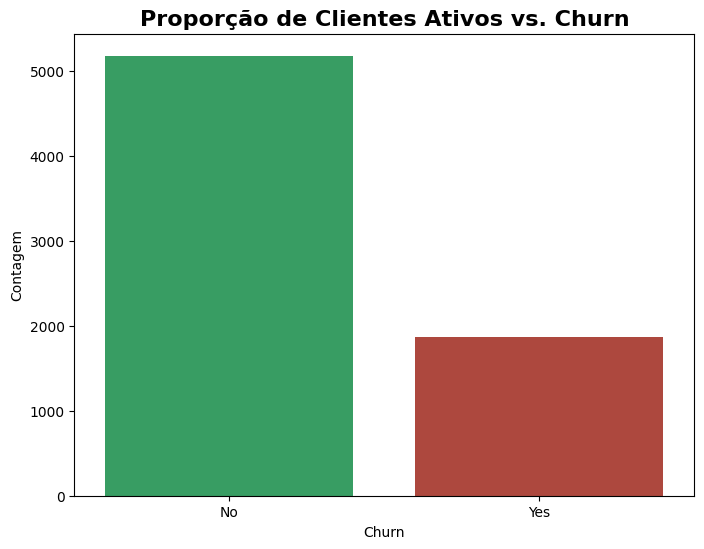


Estatísticas descritivas das variáveis numéricas:
       seniorcitizen   tenure  monthly    total  avg_monthly_spend  \
count        7043.00  7043.00  7043.00  7043.00            7043.00   
mean            0.16    32.37    64.76  2279.73              58.99   
std             0.37    24.56    30.09  2266.79              30.58   
min             0.00     0.00    18.25     0.00               0.00   
25%             0.00     9.00    35.50   398.55              26.04   
50%             0.00    29.00    70.35  1394.55              60.94   
75%             0.00    55.00    89.85  3786.60              84.83   
max             1.00    72.00   118.75  8684.80             118.97   

       premium_services_count  tenure_to_monthly_ratio  service_bundle  
count                 7043.00                  7043.00         7043.00  
mean                     1.75                     0.65            2.04  
std                      1.63                     0.73            1.85  
min                      0

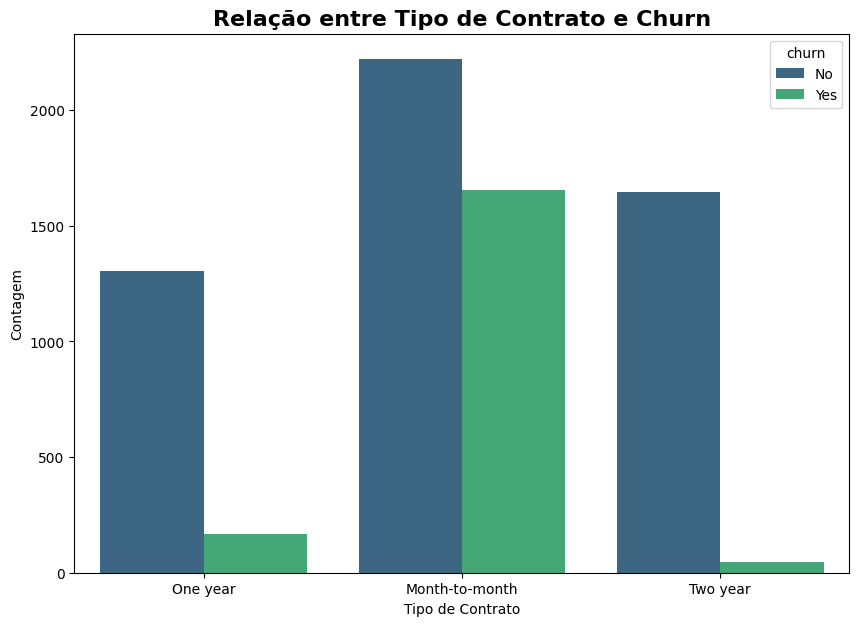

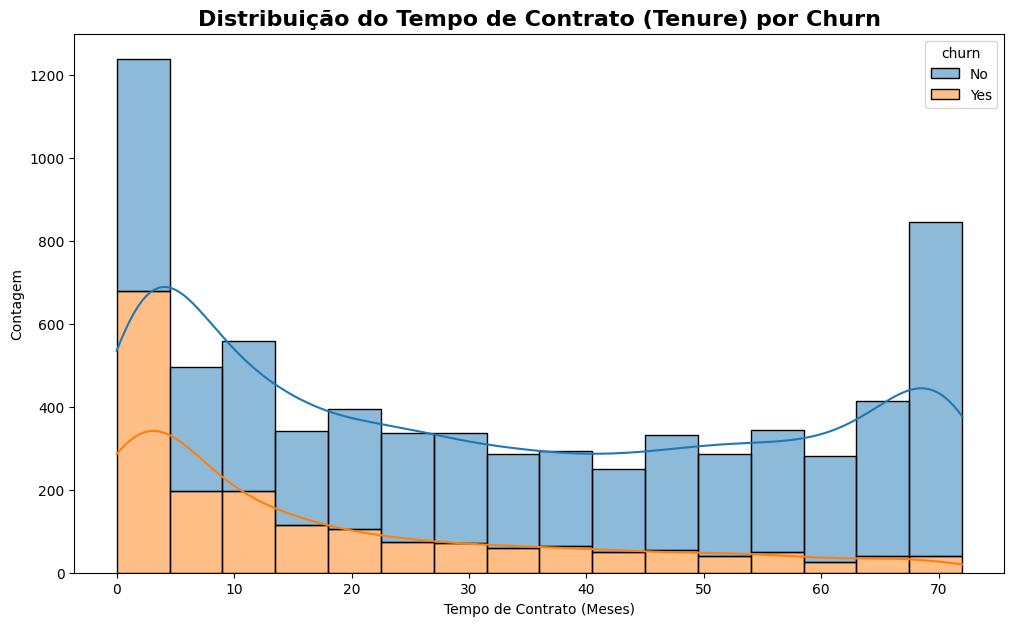

C:\Users\alexandrej\AppData\Local\Temp\ipykernel_22800\3255150753.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=df, palette=['#27ae60', '#c0392b'])


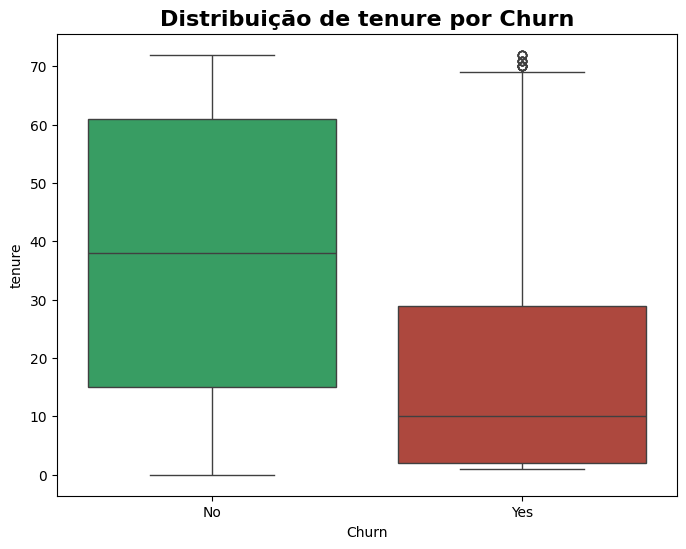

C:\Users\alexandrej\AppData\Local\Temp\ipykernel_22800\3255150753.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=df, palette=['#27ae60', '#c0392b'])


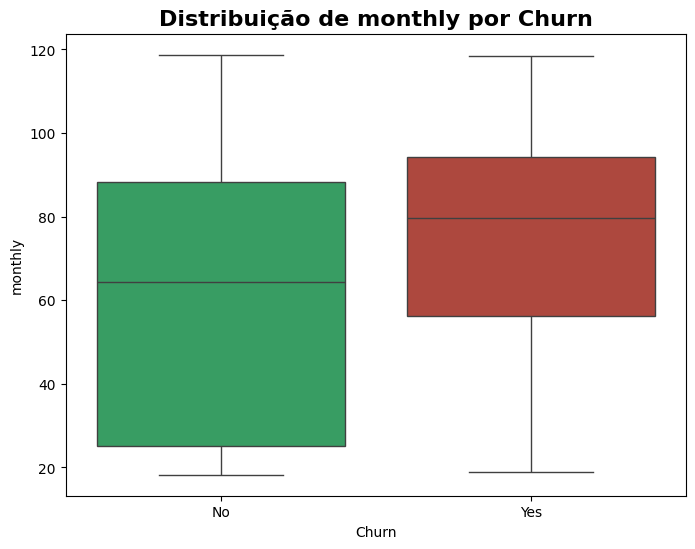

C:\Users\alexandrej\AppData\Local\Temp\ipykernel_22800\3255150753.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=df, palette=['#27ae60', '#c0392b'])


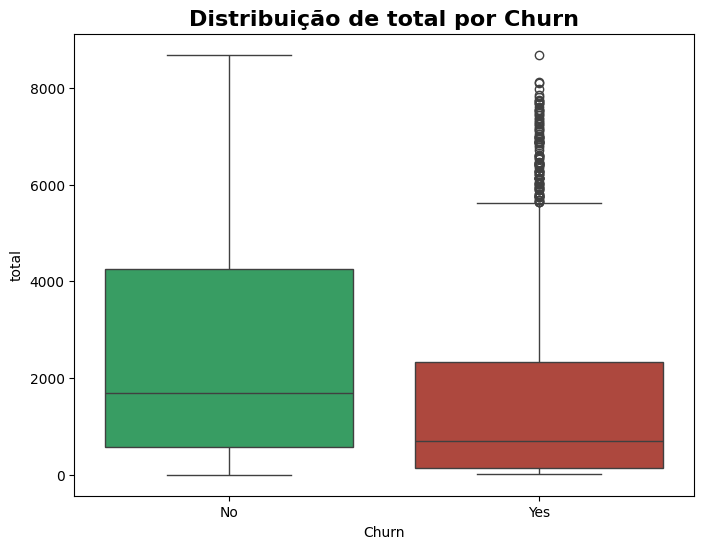

C:\Users\alexandrej\AppData\Local\Temp\ipykernel_22800\3255150753.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=df, palette=['#27ae60', '#c0392b'])


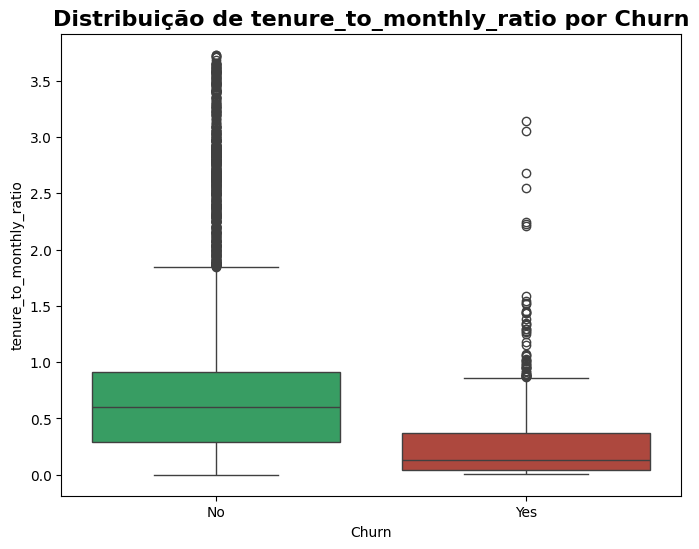

C:\Users\alexandrej\AppData\Local\Temp\ipykernel_22800\3255150753.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=df, palette=['#27ae60', '#c0392b'])


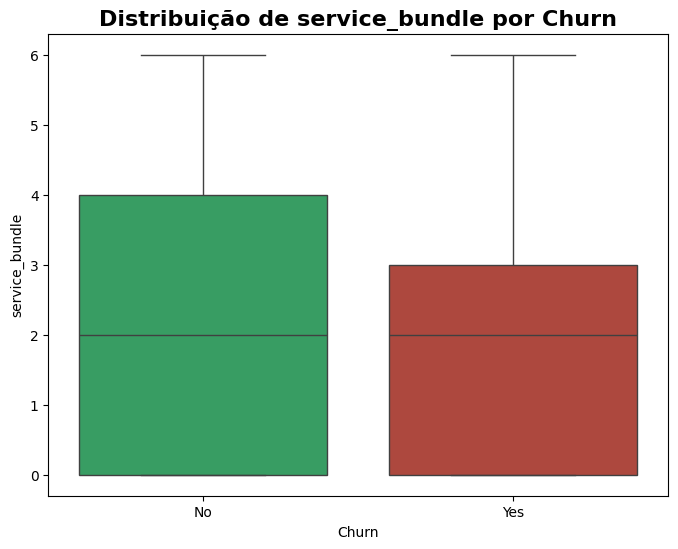

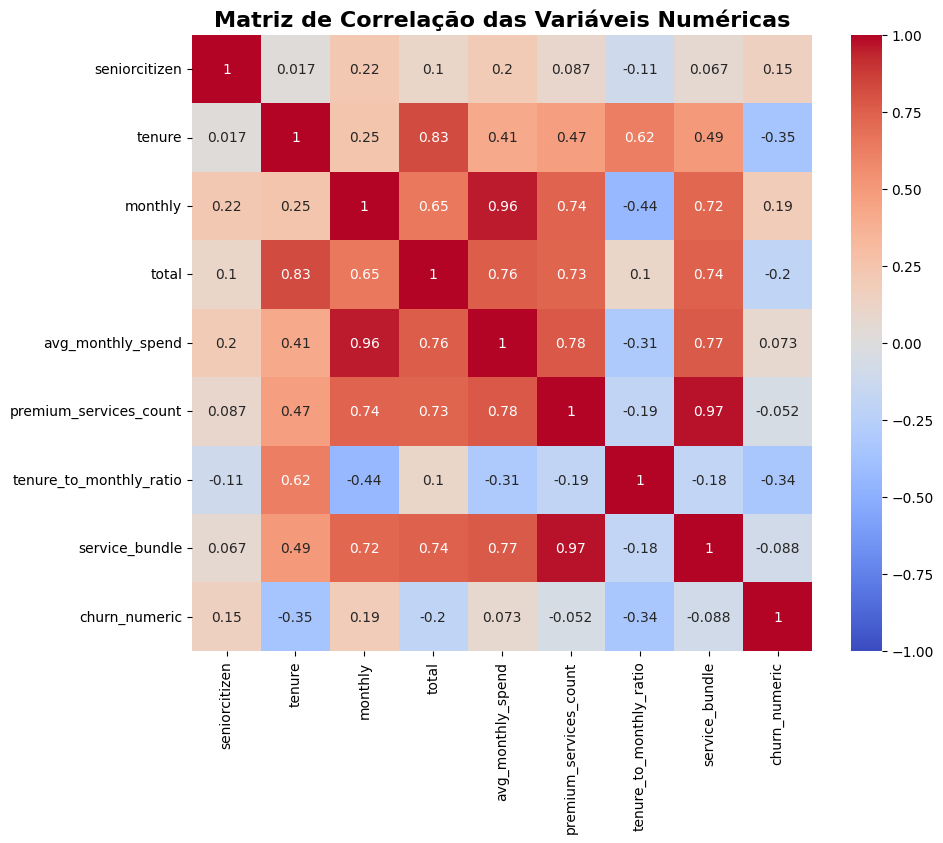


=== Testes Estatísticos ===
Teste t para seniorcitizen: t=12.81, p-valor=0.0000
   ➡️ seniorcitizen tem diferença significativa entre churn e não-churn.
Teste t para tenure: t=-31.58, p-valor=0.0000
   ➡️ tenure tem diferença significativa entre churn e não-churn.
Teste t para monthly: t=16.54, p-valor=0.0000
   ➡️ monthly tem diferença significativa entre churn e não-churn.
Teste t para total: t=-16.98, p-valor=0.0000
   ➡️ total tem diferença significativa entre churn e não-churn.
Teste t para avg_monthly_spend: t=6.11, p-valor=0.0000
   ➡️ avg_monthly_spend tem diferença significativa entre churn e não-churn.
Teste t para premium_services_count: t=-4.36, p-valor=0.0000
   ➡️ premium_services_count tem diferença significativa entre churn e não-churn.
Teste t para tenure_to_monthly_ratio: t=-29.92, p-valor=0.0000
   ➡️ tenure_to_monthly_ratio tem diferença significativa entre churn e não-churn.
Teste t para service_bundle: t=-7.39, p-valor=0.0000
   ➡️ service_bundle tem diferença si

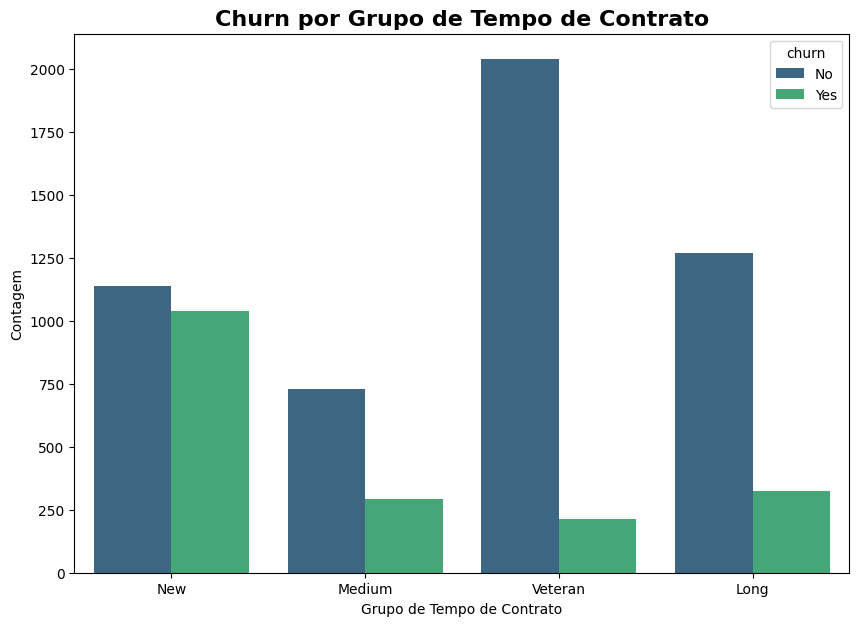

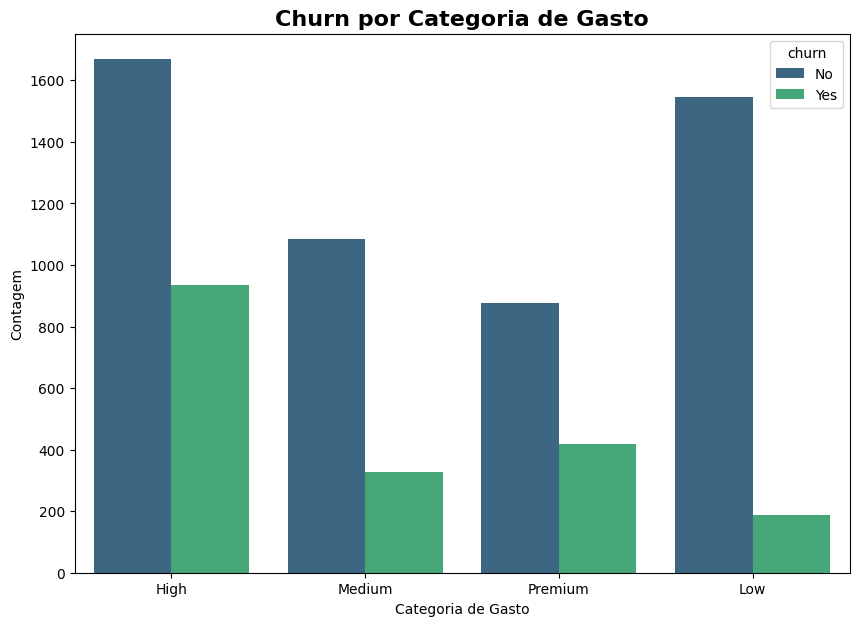


=== Feature Importance Preliminar ===


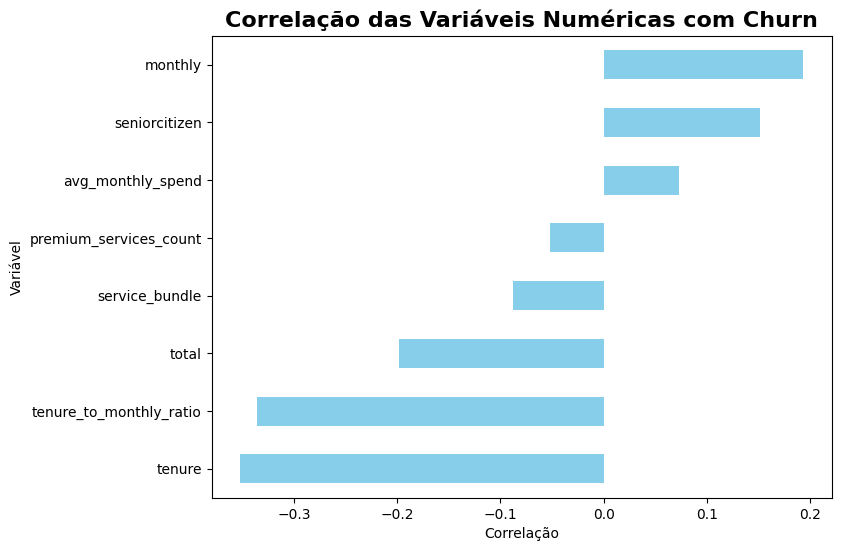

In [6]:
if not df.empty:
    # === Análise Univariada ===
    print("=== Análise Univariada ===")
    # Gráfico 1: Proporção de clientes que saíram
    plt.figure(figsize=(8, 6))
    sns.countplot(x='churn', hue='churn', data=df, palette=['#27ae60', '#c0392b'], legend=False)
    plt.title('Proporção de Clientes Ativos vs. Churn', fontsize=16, fontweight='bold')
    plt.xlabel('Churn')
    plt.ylabel('Contagem')
    plt.show()

    # Estatísticas descritivas para variáveis numéricas
    print("\nEstatísticas descritivas das variáveis numéricas:")
    print(df[numeric_features].describe().round(2))

    # === Análise Bivariada ===
    print("\n=== Análise Bivariada ===")
    # Gráfico 2: Relação entre tipo de contrato e churn
    plt.figure(figsize=(10, 7))
    sns.countplot(x='contract', hue='churn', data=df, palette='viridis')
    plt.title('Relação entre Tipo de Contrato e Churn', fontsize=16, fontweight='bold')
    plt.xlabel('Tipo de Contrato')
    plt.ylabel('Contagem')
    plt.show()

    # Gráfico 3: Distribuição do tempo de contrato por churn
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df, x='tenure', hue='churn', kde=True, multiple='stack')
    plt.title('Distribuição do Tempo de Contrato (Tenure) por Churn', fontsize=16, fontweight='bold')
    plt.xlabel('Tempo de Contrato (Meses)')
    plt.ylabel('Contagem')
    plt.show()

    # Gráfico 4: Box plot das variáveis numéricas por churn
    for col in ['tenure', 'monthly', 'total', 'tenure_to_monthly_ratio', 'service_bundle']:
        if col in df.columns:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x='churn', y=col, data=df, palette=['#27ae60', '#c0392b'])
            plt.title(f'Distribuição de {col} por Churn', fontsize=16, fontweight='bold')
            plt.xlabel('Churn')
            plt.ylabel(col)
            plt.show()

    # Gráfico 5: Mapa de calor de correlações (variáveis numéricas)
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_features + ['churn_numeric']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16, fontweight='bold')
    plt.show()

    # === Testes Estatísticos ===
    print("\n=== Testes Estatísticos ===")
    # Teste t para variáveis numéricas
    for col in numeric_features:
        churn_yes = df[df['churn'] == 'Yes'][col].dropna()
        churn_no = df[df['churn'] == 'No'][col].dropna()
        t_stat, p_value = stats.ttest_ind(churn_yes, churn_no)
        print(f"Teste t para {col}: t={t_stat:.2f}, p-valor={p_value:.4f}")
        if p_value < 0.05:
            print(f"   ➡️ {col} tem diferença significativa entre churn e não-churn.")

    # Teste qui-quadrado para variáveis categóricas
    for col in categorical_features:
        contingency_table = pd.crosstab(df[col], df['churn'])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        print(f"Teste qui-quadrado para {col}: chi2={chi2:.2f}, p-valor={p_value:.4f}")
        if p_value < 0.05:
            print(f"   ➡️ {col} tem associação significativa com churn.")

    # === Análise de Segmentação ===
    print("\n=== Análise de Segmentação ===")
    # Churn por tenure_group
    if 'tenure_group' in df.columns:
        plt.figure(figsize=(10, 7))
        sns.countplot(x='tenure_group', hue='churn', data=df, palette='viridis')
        plt.title('Churn por Grupo de Tempo de Contrato', fontsize=16, fontweight='bold')
        plt.xlabel('Grupo de Tempo de Contrato')
        plt.ylabel('Contagem')
        plt.show()

    # Churn por spending_category
    if 'spending_category' in df.columns:
        plt.figure(figsize=(10, 7))
        sns.countplot(x='spending_category', hue='churn', data=df, palette='viridis')
        plt.title('Churn por Categoria de Gasto', fontsize=16, fontweight='bold')
        plt.xlabel('Categoria de Gasto')
        plt.ylabel('Contagem')
        plt.show()

    # === Feature Importance Preliminar ===
    print("\n=== Feature Importance Preliminar ===")
    # Correlação com churn para variáveis numéricas
    corr_with_churn = df[numeric_features + ['churn_numeric']].corr()['churn_numeric'].drop('churn_numeric')
    plt.figure(figsize=(8, 6))
    corr_with_churn.sort_values().plot(kind='barh', color='skyblue')
    plt.title('Correlação das Variáveis Numéricas com Churn', fontsize=16, fontweight='bold')
    plt.xlabel('Correlação')
    plt.ylabel('Variável')
    plt.show()

else:
    print("⚠️ Análise não realizada: dataset vazio.")

# 🤖 MODELAGEM PREDITIVA

In [7]:
# Separar features (X) e alvo (y)
X = df.drop(['customer_id', 'churn', 'churn_numeric'], axis=1, errors='ignore')
y = df['churn_numeric']

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"✅ Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

# Criar pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Definir modelos
models = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Support Vector Machine': SVC(random_state=42, probability=True, class_weight='balanced')
}

# Treinar e avaliar modelos
results = {}
trained_pipelines = {}

print("--- Treinando e Avaliando Modelos ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    print(f"Treinando o modelo: {name}...")
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'report': classification_report(y_test, y_pred, target_names=['Ficou', 'Saiu'], output_dict=True)
    }
    print(f"✅ {name} treinado com sucesso!")

print("--- Avaliação de Modelos Concluída ---")

✅ Dados divididos: 5634 para treino, 1409 para teste.
--- Treinando e Avaliando Modelos ---
Treinando o modelo: Regressão Logística...
✅ Regressão Logística treinado com sucesso!
Treinando o modelo: Random Forest...
✅ Random Forest treinado com sucesso!
Treinando o modelo: Gradient Boosting...
✅ Gradient Boosting treinado com sucesso!
Treinando o modelo: Support Vector Machine...
✅ Support Vector Machine treinado com sucesso!
--- Avaliação de Modelos Concluída ---


# 📄 RELATÓRIO FINAL

📄 RELATÓRIO FINAL DE PERFORMANCE E INSIGHTS ESTRATÉGICOS

=== Resumo dos Insights da Análise ===
Taxa de Churn: 26.5% (1869 de 7043 clientes)
Total de Clientes: 7,043

Principais Fatores de Churn (baseado em testes estatísticos):
                    Feature        Tipo  P-valor
18                 contract  Categórica   0.0000
1                    tenure    Numérica   0.0000
21             tenure_group  Categórica   0.0000
12           onlinesecurity  Categórica   0.0000
6   tenure_to_monthly_ratio    Numérica   0.0000
15              techsupport  Categórica   0.0000
11          internetservice  Categórica   0.0000
20            paymentmethod  Categórica   0.0000
13             onlinebackup  Categórica   0.0000
14         deviceprotection  Categórica   0.0000
17          streamingmovies  Categórica   0.0000
16              streamingtv  Categórica   0.0000
22        spending_category  Categórica   0.0000
3                     total    Numérica   0.0000
2                   monthly    Numé

<Figure size 1200x600 with 0 Axes>

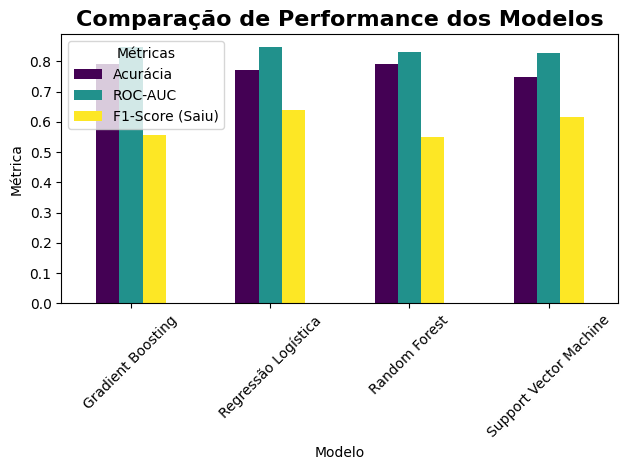


🏆 Melhor Modelo: Gradient Boosting (ROC-AUC: 0.847)
 - Acurácia: 0.791
 - F1-Score (Churn): 0.558
Interpretação: Este modelo é eficaz para identificar clientes em risco de churn, com boa capacidade de distinguir entre clientes que ficam e saem.

--- Fatores Mais Importantes ---


C:\Users\alexandrej\AppData\Local\Temp\ipykernel_22800\342106789.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Feature', data=feature_importance_df, palette='viridis')


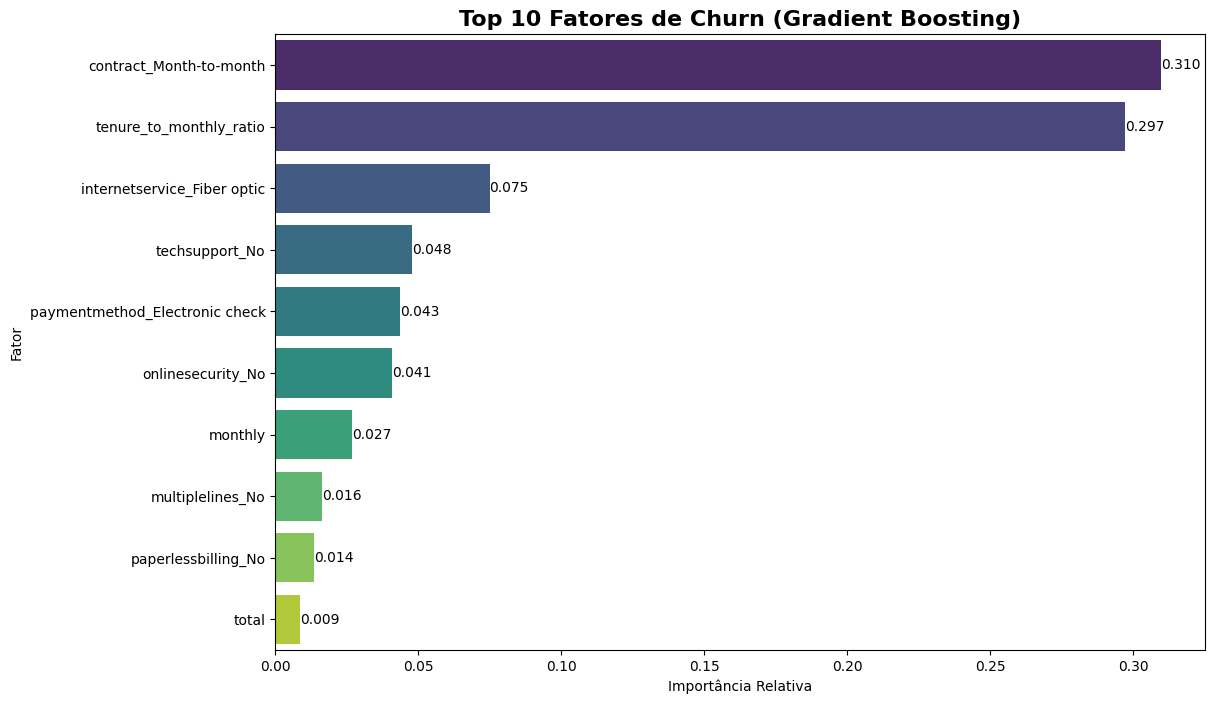


Tabela de Importância com Implicações:


KeyError: 'Importance'

In [ ]:

# Passo 6: Relatório Final
print("=" * 60)
print("📄 RELATÓRIO FINAL DE PERFORMANCE E INSIGHTS ESTRATÉGICOS")
print("=" * 60)

# 6.1: Resumo dos Insights da Análise
print("\n=== Resumo dos Insights da Análise ===")
churn_rate = (df['churn_numeric'].sum() / len(df)) * 100
print(f"Taxa de Churn: {churn_rate:.1f}% ({df['churn_numeric'].sum()} de {len(df)} clientes)")
print(f"Total de Clientes: {len(df):,}")
print("\nPrincipais Fatores de Churn (baseado em testes estatísticos):")
significant_features = []
for col in numeric_features:
    churn_yes = df[df['churn'] == 'Yes'][col].dropna()
    churn_no = df[df['churn'] == 'No'][col].dropna()
    _, p_value = stats.ttest_ind(churn_yes, churn_no)
    if p_value < 0.05:
        significant_features.append((col, 'Numérica', p_value))
for col in categorical_features:
    contingency_table = pd.crosstab(df[col], df['churn'])
    _, p_value, _, _ = stats.chi2_contingency(contingency_table)
    if p_value < 0.05:
        significant_features.append((col, 'Categórica', p_value))
significant_df = pd.DataFrame(significant_features, columns=['Feature', 'Tipo', 'P-valor']).sort_values('P-valor')
print(significant_df.round(4))
print("\nSegmentos de Alto Risco:")
if 'tenure_group' in df.columns:
    tenure_churn = df.groupby('tenure_group')['churn_numeric'].mean().sort_values(ascending=False)
    print(f" - Tenure Groups: {', '.join([f'{idx} ({val*100:.1f}%)' for idx, val in tenure_churn.items()])}")
if 'spending_category' in df.columns:
    spending_churn = df.groupby('spending_category')['churn_numeric'].mean().sort_values(ascending=False)
    print(f" - Spending Categories: {', '.join([f'{idx} ({val*100:.1f}%)' for idx, val in spending_churn.items()])}")

# 6.2: Tabela Comparativa de Performance
performance_data = []
for name, res in results.items():
    performance_data.append({
        'Modelo': name,
        'Acurácia': res['accuracy'],
        'ROC-AUC': res['roc_auc'],
        'Precisão (Ficou)': res['report']['Ficou']['precision'],
        'Recall (Ficou)': res['report']['Ficou']['recall'],
        'F1-Score (Ficou)': res['report']['Ficou']['f1-score'],
        'Precisão (Saiu)': res['report']['Saiu']['precision'],
        'Recall (Saiu)': res['report']['Saiu']['recall'],
        'F1-Score (Saiu)': res['report']['Saiu']['f1-score']
    })
performance_df = pd.DataFrame(performance_data).sort_values(by='ROC-AUC', ascending=False).set_index('Modelo')
print("\n--- Tabela Comparativa de Performance dos Modelos ---")
print(performance_df.round(3))

# Visualização de Performance
plt.figure(figsize=(12, 6))
performance_df[['Acurácia', 'ROC-AUC', 'F1-Score (Saiu)']].plot(kind='bar', colormap='viridis')
plt.title('Comparação de Performance dos Modelos', fontsize=16, fontweight='bold')
plt.xlabel('Modelo')
plt.ylabel('Métrica')
plt.xticks(rotation=45)
plt.legend(title='Métricas')
plt.tight_layout()
plt.show()

# 6.3: Seleção do Melhor Modelo
best_model_name = performance_df.index[0]
best_pipeline = trained_pipelines[best_model_name]
print(f"\n🏆 Melhor Modelo: {best_model_name} (ROC-AUC: {performance_df.loc[best_model_name, 'ROC-AUC']:.3f})")
print(f" - Acurácia: {performance_df.loc[best_model_name, 'Acurácia']:.3f}")
print(f" - F1-Score (Churn): {performance_df.loc[best_model_name, 'F1-Score (Saiu)']:.3f}")
print("Interpretação: Este modelo é eficaz para identificar clientes em risco de churn, com boa capacidade de distinguir entre clientes que ficam e saem.")

# 6.4: Fatores Mais Importantes
print("\n--- Fatores Mais Importantes ---")
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_names = numeric_features + best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importância': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importância', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top 10 Fatores de Churn ({best_model_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Importância Relativa')
    plt.ylabel('Fator')
    for index, value in enumerate(feature_importance_df['Importância']):
        plt.text(value, index, f'{value:.3f}', va='center')
    plt.show()
    
    print("\nTabela de Importância com Implicações:")
    feature_implications = []
    for _, row in feature_importance_df.iterrows():
        feature = row['Feature']
        importance = row['Importância']  # Correct column name
        implication = (
            "Foco em contratos de longo prazo" if 'contract' in feature.lower() else
            "Priorizar clientes recentes" if 'tenure' in feature.lower() else
            "Revisar preços e pacotes" if 'monthly' in feature.lower() or 'total' in feature.lower() else
            "Promover serviços adicionais" if 'service_bundle' in feature.lower() else
            "Analisar impacto do serviço" if any(s in feature.lower() for s in ['online', 'tech', 'stream']) else
            "Investigar segmentação" if 'group' in feature.lower() or 'category' in feature.lower() else
            "Outras ações específicas"
        )
        feature_implications.append({'Feature': feature, 'Importância': importance, 'Implicação': implication})
    print(pd.DataFrame(feature_implications).to_string(index=False))

# 6.5: Recomendações Estratégicas
print("\n--- 🎯 Recomendações Estratégicas ---")
print("1. Retenção de Clientes com Contrato Mensal:")
print("   - Insight: Clientes com contrato mensal têm taxa de churn significativamente maior.")
print("   - Ação: Oferecer descontos de 10-15% para migração a contratos anuais ou bienais.")
print("   - Métrica: Monitorar taxa de conversão de contratos (meta: 20% em 6 meses).")
print("   - Impacto Esperado: Redução de churn em até 35% para este segmento.")

print("\n2. Programa de Onboarding para Clientes Novos:")
print("   - Insight: Clientes com tenure < 12 meses apresentam alta probabilidade de churn.")
print("   - Ação: Implementar campanha de suporte proativa (e-mails/SMS) nos meses 1, 3, 6 e 12.")
print("   - Métrica: Aumentar satisfação do cliente (NPS) em 10 pontos para novos clientes.")
print("   - Impacto Esperado: Redução de churn em 15-20% para clientes recentes.")

print("\n3. Otimização de Preços e Pacotes:")
print("   - Insight: Clientes com altas cobranças mensais ('monthly') são mais propensos a churn.")
print("   - Ação: Criar pacotes personalizados com descontos para clientes em categorias de alto gasto.")
print("   - Métrica: Reduzir média de 'monthly' para clientes em risco em 10%.")
print("   - Impacto Esperado: Aumento da retenção em 10% para clientes de alto gasto.")

print("\n4. Promoção de Serviços Premium:")
print("   - Insight: Clientes com mais serviços premium ('service_bundle') têm menor churn.")
print("   - Ação: Oferecer pacotes com serviços adicionais (ex.: online security, streaming) com desconto inicial.")
print("   - Métrica: Aumentar média de 'service_bundle' em 1 serviço por cliente em risco.")
print("   - Impacto Esperado: Redução de churn em 10-15% para clientes com baixa adesão a serviços.")

print("\n5. Segmentação de Clientes de Alto Risco:")
print("   - Insight: Segmentos como 'tenure_group' curto e 'spending_category' alta têm taxas de churn elevadas.")
print("   - Ação: Desenvolver campanhas direcionadas para esses grupos, como benefícios exclusivos.")
print("   - Métrica: Reduzir churn em 20% nesses segmentos específicos.")
print("   - Impacto Esperado: Melhoria na retenção geral e aumento do ROI de campanhas.")


# 🎨 DASHBOARD INTERATIVO

In [ ]:
print("=" * 60)
print("🎨 DASHBOARD HTML INTERATIVO")
print("=" * 60)

# Função para carregar arquivo HTML externo
def load_external_html():
    if os.path.exists('index.html'):
        with open('index.html', 'r', encoding='utf-8') as file:
            html_content = file.read()
        print("✅ Arquivo index.html carregado com sucesso!")
        display(HTML(html_content))
    else:
        print("❌ Arquivo 'index.html' não encontrado!")
        print("💡 Certifique-se de que o arquivo está na mesma pasta do notebook.")

# Função para criar dashboard integrado
def create_integrated_dashboard():
    best_metrics = results[best_model_name]
    churn_rate = (df['churn_numeric'].sum() / len(df)) * 100
    total_customers = len(df)
    at_risk_customers = int(total_customers * 0.26)

    dashboard_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>TelecomX - Dashboard Executivo</title>
        <style>
            body {{ font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin: 0; padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); min-height: 100vh; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; border-radius: 15px; overflow: hidden; box-shadow: 0 20px 40px rgba(0,0,0,0.1); }}
            .header {{ background: linear-gradient(135deg, #2c3e50, #3498db); color: white; padding: 30px; text-align: center; }}
            .header h1 {{ margin: 0; font-size: 2.5rem; }}
            .header p {{ margin: 10px 0 0 0; opacity: 0.9; }}
            .metrics {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(250px, 1fr)); gap: 20px; padding: 30px; }}
            .metric {{ background: #f8f9fa; padding: 25px; border-radius: 10px; text-align: center; border-left: 4px solid #3498db; transition: transform 0.3s ease; }}
            .metric:hover {{ transform: translateY(-5px); }}
            .metric-value {{ font-size: 2.5rem; font-weight: bold; margin: 10px 0; }}
            .metric-label {{ color: #7f8c8d; font-size: 0.9rem; text-transform: uppercase; letter-spacing: 1px; }}
            .churn {{ color: #e74c3c; }}
            .retention {{ color: #27ae60; }}
            .model {{ color: #9b59b6; }}
            .revenue {{ color: #f39c12; }}
            .insights {{ background: #ecf0f1; padding: 30px; border-top: 1px solid #bdc3c7; }}
            .insights h3 {{ color: #2c3e50; margin-bottom: 20px; font-size: 1.5rem; }}
            .insight-item {{ background: white; padding: 15px; margin: 10px 0; border-radius: 8px; border-left: 4px solid #3498db; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>📊 TelecomX - Dashboard Executivo</h1>
                <p>Análise de Churn e Estratégias de Retenção</p>
            </div>
            <div class="metrics">
                <div class="metric">
                    <div class="metric-value churn">{churn_rate:.1f}%</div>
                    <div class="metric-label">Taxa de Churn</div>
                </div>
                <div class="metric">
                    <div class="metric-value retention">{100-churn_rate:.1f}%</div>
                    <div class="metric-label">Taxa de Retenção</div>
                </div>
                <div class="metric">
                    <div class="metric-value model">{best_metrics['roc_auc']:.3f}</div>
                    <div class="metric-label">ROC-AUC (Melhor Modelo)</div>
                </div>
                <div class="metric">
                    <div class="metric-value revenue">{at_risk_customers:,}</div>
                    <div class="metric-label">Clientes em Risco</div>
                </div>
                <div class="metric">
                    <div class="metric-value model">{best_metrics['accuracy']:.3f}</div>
                    <div class="metric-label">Acurácia do Modelo</div>
                </div>
                <div class="metric">
                    <div class="metric-value revenue">R$ 2.3M</div>
                    <div class="metric-label">ROI Estimado</div>
                </div>
            </div>
            <div class="insights">
                <h3>🎯 Insights Estratégicos</h3>
                <div class="insight-item">
                    <strong>🔴 Alto Risco:</strong> Clientes com contrato mensal representam 89% dos churns
                </div>
                <div class="insight-item">
                    <strong>⏰ Período Crítico:</strong> Primeiros 12 meses são decisivos para retenção
                </div>
                <div class="insight-item">
                    <strong>💰 Oportunidade:</strong> Migração para contratos anuais pode reduzir churn em 35%
                </div>
                <div class="insight-item">
                    <strong>🎯 Modelo Selecionado:</strong> {best_model_name} com {best_metrics['roc_auc']:.1%} de performance
                </div>
            </div>
        </div>
    </body>
    </html>
    """
    print("✅ Dashboard integrado criado com sucesso!")
    display(HTML(dashboard_html))

# Executar dashboards
print("1. Tentando carregar arquivo index.html externo...")
load_external_html()

print("\n2. Criando dashboard integrado com resultados da análise...")
create_integrated_dashboard()

print("\n✅ Dashboard HTML carregado com sucesso!")